# Modelling Background Data
This notebook attempts to use some basic functions and fitting algorithms to have an analytical function to describe the LHCb background data.

## Setup & Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utilities import Data, Cut, Plots, Consts

In [2]:
SFNAME, SSUFFIX = Consts().get_simulated_tuple()
RFNAME, RSUFFIX = Consts().get_real_tuple()
sd, rd = Data(SFNAME, SSUFFIX), Data(RFNAME, RSUFFIX)
sdc, rdc = Cut(sd), Cut(rd)

## Setup Plotting Functions
Plotting is a pain I just make some simple functions here so that the plots are all consistent and I do not have to repeat code what feels like 500 times.

In [16]:
def simple_hist(invariant_masses, label="Empty label", normalised=True, bins=175, figsize=(11, 9), savefig=None):
    # Create bins evenly spaced bins over the range of invariant_masses provided
    bin_space = np.linspace(int(np.round(np.min(invariant_masses), 0)), int(np.round(np.max(invariant_masses), 1)), bins+1)
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    hist_data = ax.hist(invariant_masses, bins=bin_space, density=normalised, edgecolor='k', label=label)
    ax.set_ylabel(f'Frequency, normalised = {normalised}')
    ax.set_xlabel('Invariant mass (MeV)')
    plt.legend(frameon=False)
    plt.title('Histogram of Invariant Mass')
    plt.show()
    if savefig is not None:
        plt.savefig(savefig)
    return hist_data

def hist_with_errors(invariant_masses, label="Empty Label", normalised=True, bins=175, bin_space=None, figsize=(11,9), savefig=None, zoom=None):
    if bin_space is None:
        bin_space = np.linspace(int(np.round(np.min(invariant_masses), 0)), int(np.round(np.max(invariant_masses), 1)), bins+1)
    bin_centr = [(bin_space[i] + bin_space[i+1])/2 for i in range(len(bin_space) - 1)]
    bin_width = (bin_space[1] - bin_space[0])
    hist_frq_no_norm = np.histogram(invariant_masses, bin_space, density=False)
    hist_frq = np.histogram(invariant_masses, bin_space, density=normalised) # Get the normalisation factor from this
    hist_err = np.sqrt(hist_frq_no_norm[0]) # Error on the bin is proportional to the sqrt of the counts
    if normalised: # Adjust error bars to be smaller
        hist_err *= (hist_frq[0]/hist_frq_no_norm[0])
        # This will reduce the error by the normalisation factor
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.bar(bin_centr, hist_frq[0], yerr=hist_err, width=bin_width, edgecolor='k', label=label)
    if zoom is not None:
        ax.set_xlim(zoom[0], zoom[1])
    ax.set_ylabel(f'Frequency (Normalised={normalised})')
    ax.set_xlabel('Invariant Mass (MeV)')
    plt.title('Histogram of Invariant Mass')
    plt.legend(frameon=False)
    if savefig is not None:
        plt.savefig(savefig)
    plt.show()
    return hist_frq[0], hist_err, bin_space, bin_centr

def bar_with_errs(data, bin_width, labels, figsize=(11, 9), savefig=None, title=None, show=True):
    """
    data is a list of  numpy array such that each row is a data item with the first
    column the y-position and the 2nd column the yerr and the 3rd the x
    """
    if type(data) is not list:
        data = [data]
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    for i, dat in enumerate(data):
        ax.bar(dat[:,2], dat[:,0], yerr=dat[:,1], width=bin_width, label=labels[i], edgecolor='k')
    ax.set_xlabel('Mass (MeV)')
    ax.set_ylabel('Frequency')
    if title is not None:
        plt.title(title)
    plt.legend(frameon=False)
    if show == True:
        plt.show()
    else:
        plt.close()
    if savefig is not None:
            plt.savefig(savefig)
    return fig, ax

## Fetch Data & Pre-Analyse

In [93]:
df = rd.fetch_features(['Lb_M']) 
# Get the invariant masses from the real data tuple

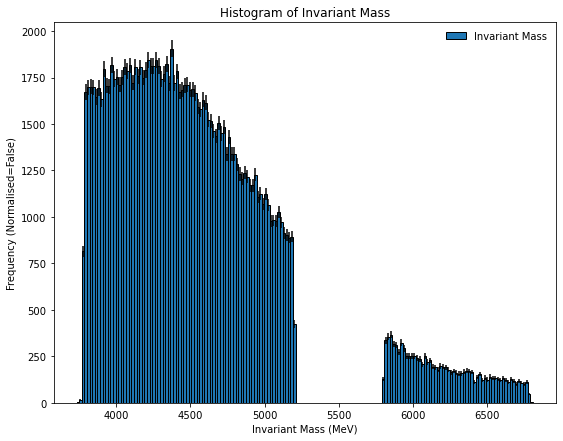

In [94]:
dat = hist_with_errors(df, label='Invariant Mass', figsize=(9, 7), normalised=False)

In [6]:
frequencies, errors, spacings, centres = dat
# Split out the dat tuple to the appropriate variables

Apply a basic masscut to remove the rubbish data at the extremes which for now we arbitraruly define as our region of interest $\pm800$ MeV. But first combine the calculated frequencies and errors into an array.

In [53]:
data_with_errs = np.array([frequencies, errors, centres]).T
# Combine the data into a big array for ease in the next bit of code
roi = [4400, 6600]
# Define the region of interest, this is arbitrarily set by me currently
data_with_errs = data_with_errs[data_with_errs[:,2] >= 4400, :]
data_with_errs = data_with_errs[data_with_errs[:,2] <= 6600, :]
bin_width = spacings[1] - spacings[0]

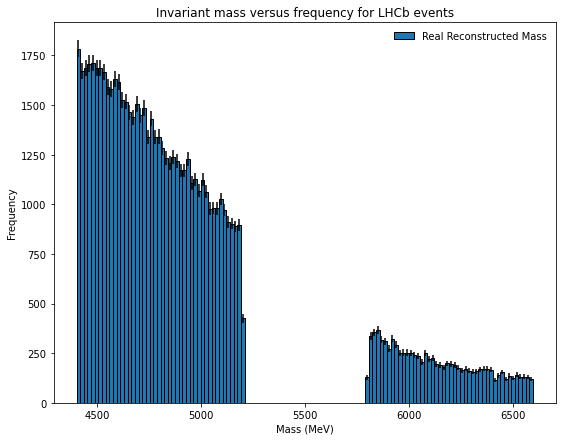

In [54]:
fig, ax = bar_with_errs(data_with_errs, bin_width=bin_width, labels=['Real Reconstructed Mass'], figsize=(9, 7), title='Invariant mass versus frequency for LHCb events')

## Cleaning for Fitting
We now have the real background data with errors on each bin. We now want to try and fit a variety of different functions to this background to model it well. We will use a variety of different fitting routines with various levels of sophistication. Firstly however, we take the data used to setup the previous plot and remove all the empty bins in the blinded region as not to influence the fitting routines.

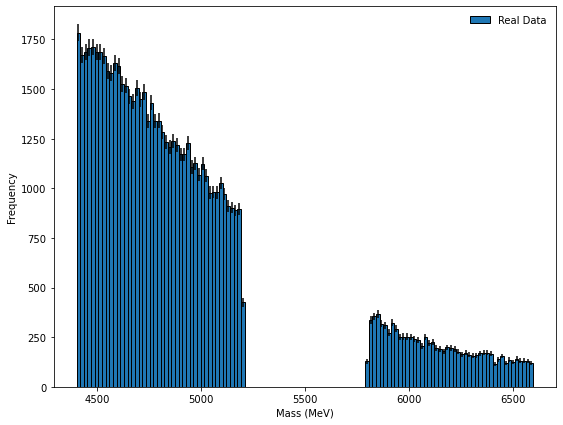

In [55]:
# Find the start and ends of the bins where there is actually data so we can set an appropriate x-lim
first_non_zero = (data_with_errs[:,0] != 0).argmin(axis=0)
# Apply a mask where all zeros are False and rest is true
last_non_zero = data_with_errs[:,0].shape[0] - np.flip((data_with_errs[:,0]!=0)).argmin(axis=0)

data_rm_blinded = np.delete(data_with_errs, np.arange(first_non_zero, last_non_zero), axis=0)
# Store the new data with the blinded data removed in data_rm_blinded

fig, ax = bar_with_errs(data_rm_blinded, bin_width, labels=['Real Data'], figsize=(9,7))
# Plot the data to make sure nothing crazy has happened

## Define Functions
Now we define some functions that we will attempt to fit to these data using a range of fitting routines starting with a least-squares.

In [56]:
def exponential(x, A, B, C, k):
    """
    A simple exponential function with a shift of B and amplitude A
    """
    return (A*np.exp(-((k*x)+B)))+C

def gaussian(x, mu, sigma):
    """
    A standard Gaussian distribution (not normalised)
    """
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp((x-mu)**2/(2*(sigma**2)))

def power(x, A, B, C, D):
    """
    A simple power law function of the form A(x-B)^C
    """
    return A*(x-B)**(C) + D

def logarithmic(x, A, B, C):
    """
    A logarithm-like function of the form f(x)=-Bln((x-A)) + C
    """
    return -(B * np.log(x-A)) + C

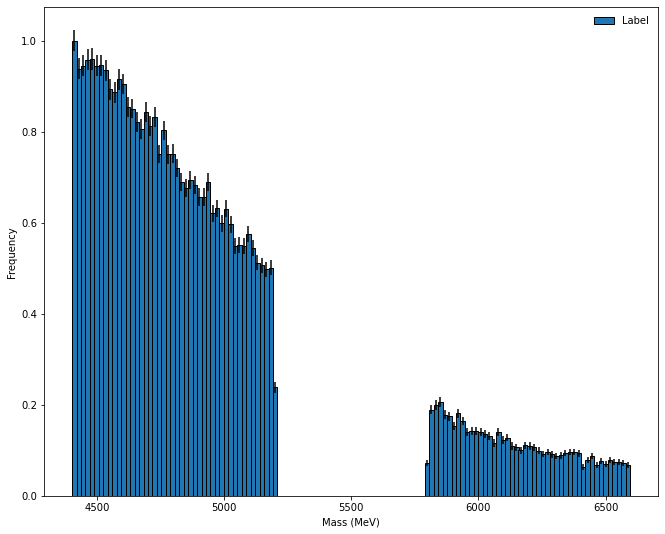

In [89]:
# Scipy works better when data is not enormous or tiny so we renormalise the data such that its peak is at 1 NOT the total frequency = 1. I.e. data = data/max(data)
data_rm_blind_norm = np.column_stack([(data_rm_blinded[:,0:2]/np.max(data_rm_blinded[:,0])), data_rm_blinded[:,2]])
fig2, ax2 = bar_with_errs(data_rm_blind_norm, bin_width, ['Label'])

[17494.27151849  3067.91563588]


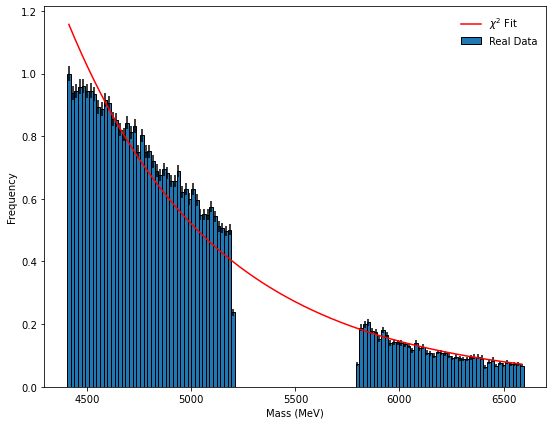

In [92]:
# Now we fit the above
from scipy.optimize import curve_fit 

# Use the most basic of fitting routines first
popt, pcov = curve_fit(gaussian, data_rm_blind_norm[:,2], data_rm_blind_norm[:,0], p0=[8000, 600], sigma=data_rm_blind_norm[:,1])
print(popt)
# power: -1, 0, 0.5, 1e+3
# Logarithmic: [ 3434.87218216  1311.25827559 10596.15388163]

func_plot_range = np.linspace(np.min(data_rm_blind_norm[:,2]), np.max(data_rm_blind_norm[:,2]), 500)
fig, ax = plt.subplots(1, 1, figsize=(9, 7))
ax.bar(data_rm_blind_norm[:,2], data_rm_blind_norm[:,0], yerr=data_rm_blind_norm[:,1], edgecolor='k', width=bin_width, label='Real Data')
ax.plot(func_plot_range, gaussian(func_plot_range, *popt), label=r'$\chi^2$ Fit', c='r')
ax.set_ylabel('Frequency')
ax.set_xlabel('Mass (MeV)')
plt.legend(frameon=False)
plt.show()